## Introduction

In recent years, bike-sharing has became one of the most popular ways for city residents to travel around city area. The huge and keep-growing demand of bike sharing makes bike sharing become a hot topic for investors, entrepreneurs, and start-up teams. However, for a team who want to successfully run a bike-sharing service, they have to gain many technical and managerial know-hows besides knowing how to raise money from the capital market. Among those know-hows, the most important one probably is to know how to accurately predict the number of bikes needed for the system to run at any given point of time. Over-preparing bikes will hurt the profitibility of the system, and under-preparing bikes leads to low system reliability. In this research, we apply exploratory data analysis techniques to system usage record generated by a real bike sharing system, trying to explore the important factors which determine the bike sharing usage count in any given point of time.

## Data Definition

The dataset we are going to analyze is a record of system usage of Capital Bike Sharing, a bike sharing system operates in Washington, D.C., USA. This dataset is compiled by Fanaee-T and Gama and shared through UCI machine learning repository. It contains two years of hourly-aggregated bike system usage count data. The record begins on 2011-01-01, ends on 2012-12-31. It collects total 17379 data points.

The dataset consists of three sets of variables, with total 16 variables. The first set of variables are the usage count data generated by the system in a specific hour. The count can further split into three the parts, including the count generated by registered user, the count generated by unregistered user, and the total usage count. The second set of variables are the date-time information about the hour which usage count was generated, including the hour, the date, day-of-the-week, season-of-the-year (Q1 ~ Q4), weekday or weekend, and workday or holiday. The last set of variables are the local weather information of the hour, including temperature, apparent temperature, humidity, wind speed, and the weather condition types (sunny, cloudy, mist, rain, snow…etc). You can find the list and the summaries of the variables in the following table.

## Exploratory Analysis

In [3]:
library(dplyr)
library(data.table)
library(ggplot2)
library(GGally)
library(RColorBrewer)

setwd('D:\\docs\\[IU lesson]\\exploratory data analysis\\final')
data = read.csv('hour.csv')
data = as.data.table(data)


## format data
data[,season:= factor(season, labels = c('winter','spring','summer','fall'))]
data[,hour:=factor(hr)]
data[,workingday:= factor(workingday, labels = c('non_workday','workday'))]
data[,date := as.Date(dteday)]
data[,month:= factor(mnth)]
data[,year:= factor(yr,labels=c(2011,2012))]
data[,weather:=recode(weathersit, '4'=3, '3'=3, '2'=2, '1'=1)]
data[,weather:= factor(weather, labels = c('Normal','Cloudy','Rain or Snow'))]
data[,rainy:=recode(weathersit, '4'=1, '3'=1, '2'=0, '1'=0)]
data[,rainy:=factor(rainy, labels = c('Normal','Rain or Sanow'))]
data[,temperature := temp*47-8]
data[,app_temperature:= atemp*66-16]
data[,humidity := hum*100]
data[,windspeed := windspeed*67]

# some weird data
data[,err:=as.numeric(humidity==0)] # have to drop if we want to feet a model on humidity
# data[temperature>10 & app_temperature<0,] # since we use temperature instead of apparent temperature, we can keep this group of data



- Season
- Weather Condition
- Temperature and Humidity

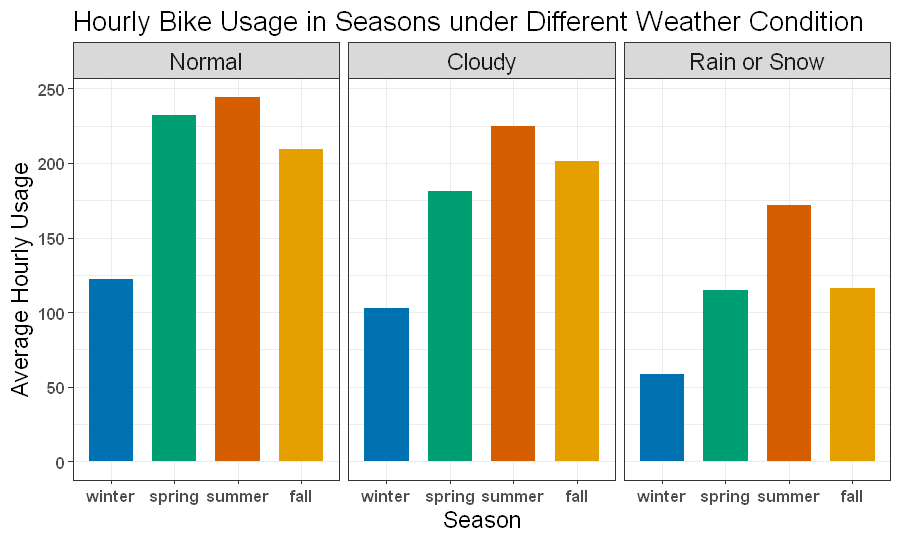

In [4]:
meand=data[,.(sum_cnt=sum(cnt)/length((unique(instant)))), by=c('season','weather')]
options(repr.plot.width=7.5, repr.plot.height=4.5)
ggplot(meand, aes(x=season, y=sum_cnt, fill=season))+
  geom_bar(stat="identity", width=0.7)+
  facet_wrap(~weather)+
  scale_fill_manual(values=c("#0072B2", "#009E73", "#D55E00", "#E69F00"))+
  labs(title="Hourly Bike Usage in Seasons under Different Weather Condition",
       x='Season', y='Average Hourly Usage')+
  theme_bw()+
  theme(plot.title = element_text(size='16'),
        axis.text = element_text(size='10', face='bold'),
        axis.title = element_text(size='14'),
        legend.position='none',
        #legend.position="bottom", legend.box = "horizontal",
        strip.text = element_text(size=14))
  

In [13]:
data[, temp_grp := cut(temperature, c(-10,0,10,20,30,40))]
data[, hum_grp:= cut(humidity, c(50,60,70,80,90,100))]

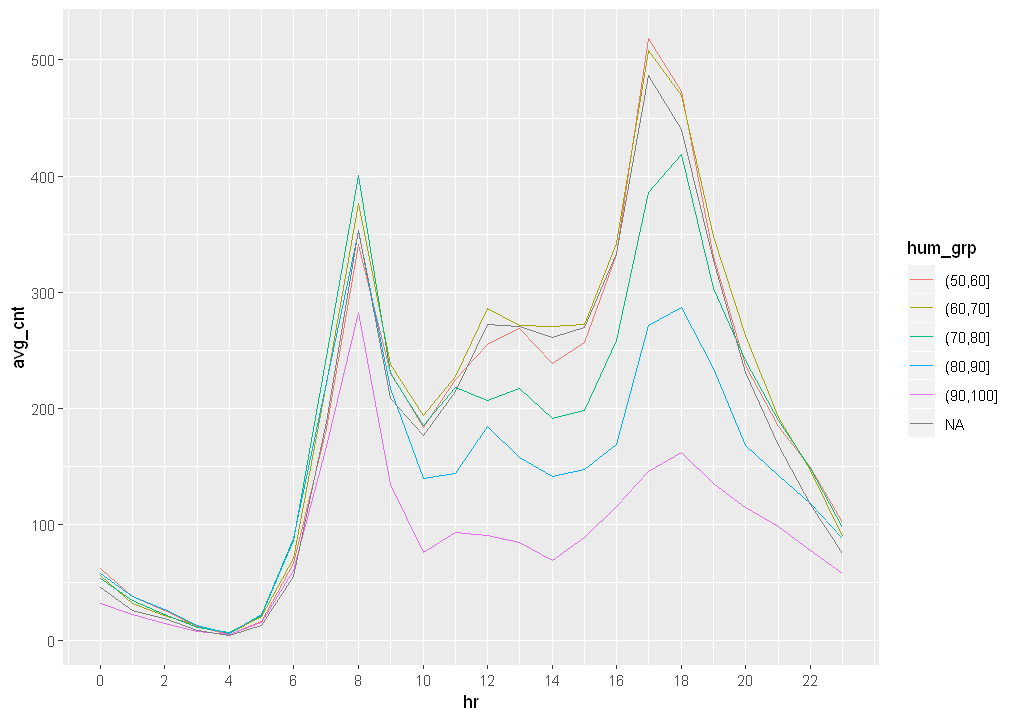

In [21]:
meand=data[,.(avg_cnt=mean(cnt)), by=c('hr','hum_grp')]
options(repr.plot.width=8.5, repr.plot.height=6)
ggplot(meand, aes(x=hr, y=avg_cnt, group=hum_grp, color=hum_grp))+
  geom_line()+
  scale_x_continuous(breaks=seq(0,23,2))

In [ ]:
+
  facet_wrap(~ workingday+season, ncol =4)+
  labs(title = 'Bike Rental Count on Hour-of-the-Day',
       x='hour',y='bicycle rental count')+
  theme(plot.title = element_text(size='18'),
        axis.text = element_text(size='9', face='bold'),
        axis.title = element_text(size='14',),
        legend.position="bottom", legend.box = "horizontal")

###  Usage Count v.s. Date-Time Properties

Observation:
- different usage pattern along hour-of-the-day for workday and non-workday
- different usage level between seasons-of-the-year
- different usage level between years
- the variation of the usage count

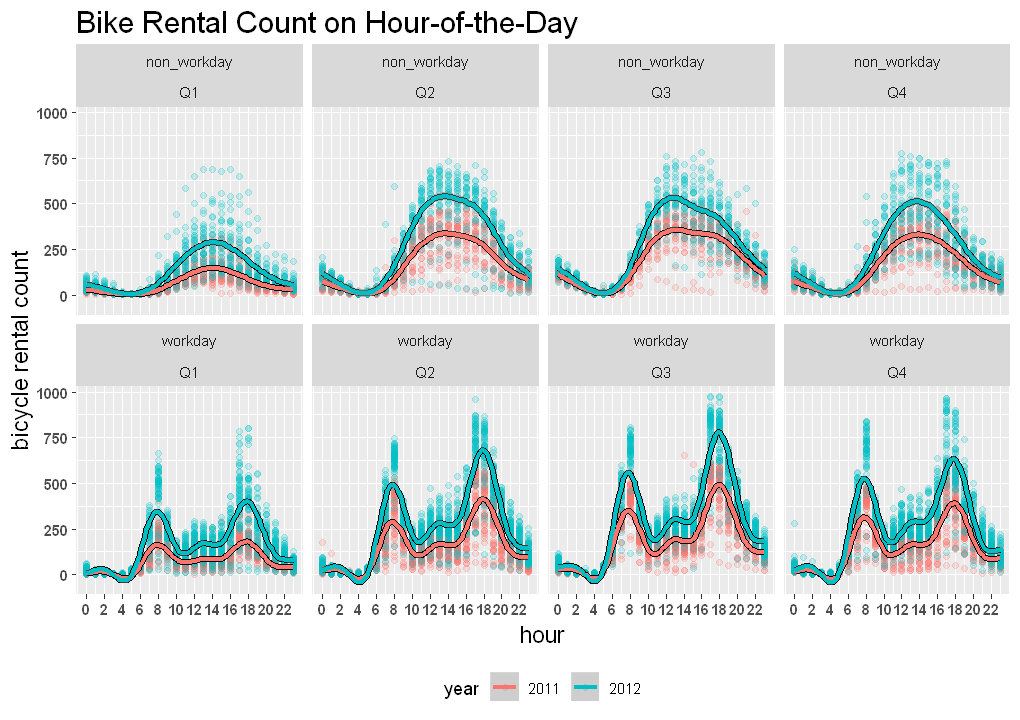

In [130]:
options(repr.plot.width=8.5, repr.plot.height=6)
ggplot(data, aes(x=hr, y=cnt, group=year, color=year))+
  geom_point(alpha=0.2)+
  geom_smooth(method = 'gam', formula=y ~ s(x, bs = "cs"), color='black', size=1.7)+
  geom_smooth(method = 'gam', formula=y ~ s(x, bs = "cs"), size=1.4)+
  scale_x_continuous(breaks=seq(0,23,2))+
  facet_wrap(~ workingday+season, ncol =4)+
  labs(title = 'Bike Rental Count on Hour-of-the-Day',
       x='hour',y='bicycle rental count')+
  theme(plot.title = element_text(size='18'),
        axis.text = element_text(size='9', face='bold'),
        axis.title = element_text(size='14',),
        legend.position="bottom", legend.box = "horizontal")

## Usage Count v.s. Local Weather

From the preliminary analysis, we know that the impact of wind speed on usage count is insignificant. We also know that the temperature impact to usage count is very similar to the apparent temperature's impact to usage count. Thus, in this section, when discussing weather effect on the usage count, we will skip the discussion on wind speed and apparent temperature, and focus on the rest of three weather factors, i.e., temperature, humidity, and the weather type. 

Observation:
- Usage count rises as temperature rises until temperature is too high (over 30 degree)
- Usage count decreases as humidity rises. 
- Usage count of non_workday is slightly more responsive to "bad weather" than the usage count of workday.

In [ ]:


g_lower <- function(data, mapping, ...){
  ggplot(data, mapping)+
    geom_point(alpha=0.2)+
    geom_smooth(method = 'gam', formula=y ~ s(x, bs = "cs"), color='black', size=1.3)+
    geom_smooth(method = 'gam', formula=y ~ s(x, bs = "cs"), size=1)
}

g_diag<- function(data, mapping, ...) {
  ggplot(data = data, mapping=mapping) +
    geom_density(..., alpha = 0.6) 
}

ggpairs(data, columns = c('temperature','app_temperature','windspeed','humidity','cnt'),
        mapping = aes(group=weather, color=weather),
        lower=list(continuous=g_lower), diag = list(continuous=g_diag)
         )

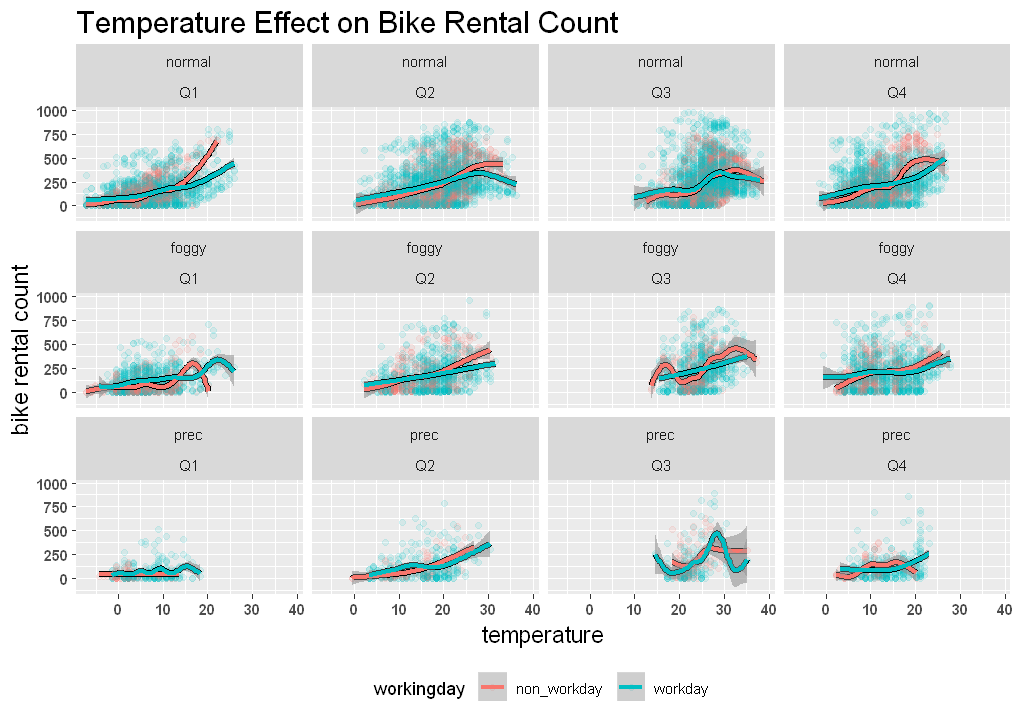

In [48]:
options(repr.plot.width=8.5, repr.plot.height=6)
ggplot(data, aes(x=temperature, y=cnt, group=workingday, color=workingday))+
  geom_point(alpha=0.1)+
  geom_smooth(method = 'gam', formula=y ~ s(x, bs = "cs"), color='black', size=1.7)+
  geom_smooth(method = 'gam', formula=y ~ s(x, bs = "cs"), size=1.4)+
  facet_wrap(~weather+season, ncol=4)+
  labs(title = 'Temperature Effect on Bike Rental Count',y='bike rental count')+
  theme(plot.title = element_text(size='18'),
        axis.text = element_text(size='9', face='bold'),
        axis.title = element_text(size='14',),
        legend.position="bottom", legend.box = "horizontal")
  

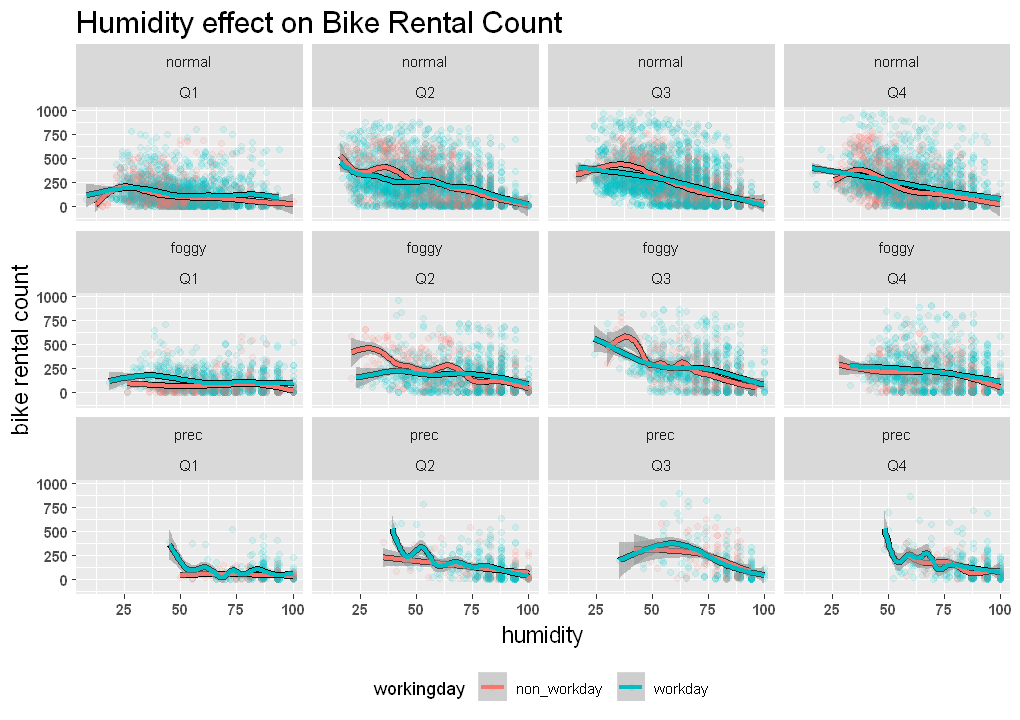

In [47]:
options(repr.plot.width=8.5, repr.plot.height=6)
ggplot(data[humidity!=0,], aes(x=humidity, y=cnt, group=workingday, color=workingday))+
  geom_point(alpha=0.1)+
  geom_smooth(method = 'gam', formula=y ~ s(x, bs = "cs"), color='black', size=1.7)+
  geom_smooth(method = 'gam', formula=y ~ s(x, bs = "cs"), size=1.4)+
  facet_wrap(~weather+season, ncol=4)+
  labs(title = 'Humidity Effect on Bike Rental Count',y='bike rental count')+
  theme(plot.title = element_text(size='18'),
        axis.text = element_text(size='9', face='bold'),
        axis.title = element_text(size='14',),
        legend.position="bottom", legend.box = "horizontal")

## Modeling as a way of Exploratory Analysis

In [22]:
# model fit 
mdl = lm(data = data[err==0,], formula = cnt ~ year + season + hour*workingday + 
                                               weather +
                                               temperature:weather:season + 
                                               humidity:weather:season)
summary(mdl)


Call:
lm(formula = cnt ~ year + season + hour * workingday + weather + 
    temperature:weather:season + humidity:weather:season, data = data[err == 
    0, ])

Residuals:
    Min      1Q  Median      3Q     Max 
-390.85  -43.25   -0.80   40.66  433.10 

Coefficients:
                                     Estimate Std. Error t value Pr(>|t|)    
(Intercept)                         -81.85690    7.09358 -11.540  < 2e-16 ***
year2012                             84.58710    1.18259  71.527  < 2e-16 ***
seasonQ2                            118.59868    7.06936  16.776  < 2e-16 ***
seasonQ3                            349.36108   13.32651  26.215  < 2e-16 ***
seasonQ4                            124.09121    7.23332  17.155  < 2e-16 ***
hour1                               -17.40637    7.11868  -2.445 0.014488 *  
hour2                               -31.54391    7.13590  -4.420 9.91e-06 ***
hour3                               -57.02065    7.14515  -7.980 1.55e-15 ***
hour4                       

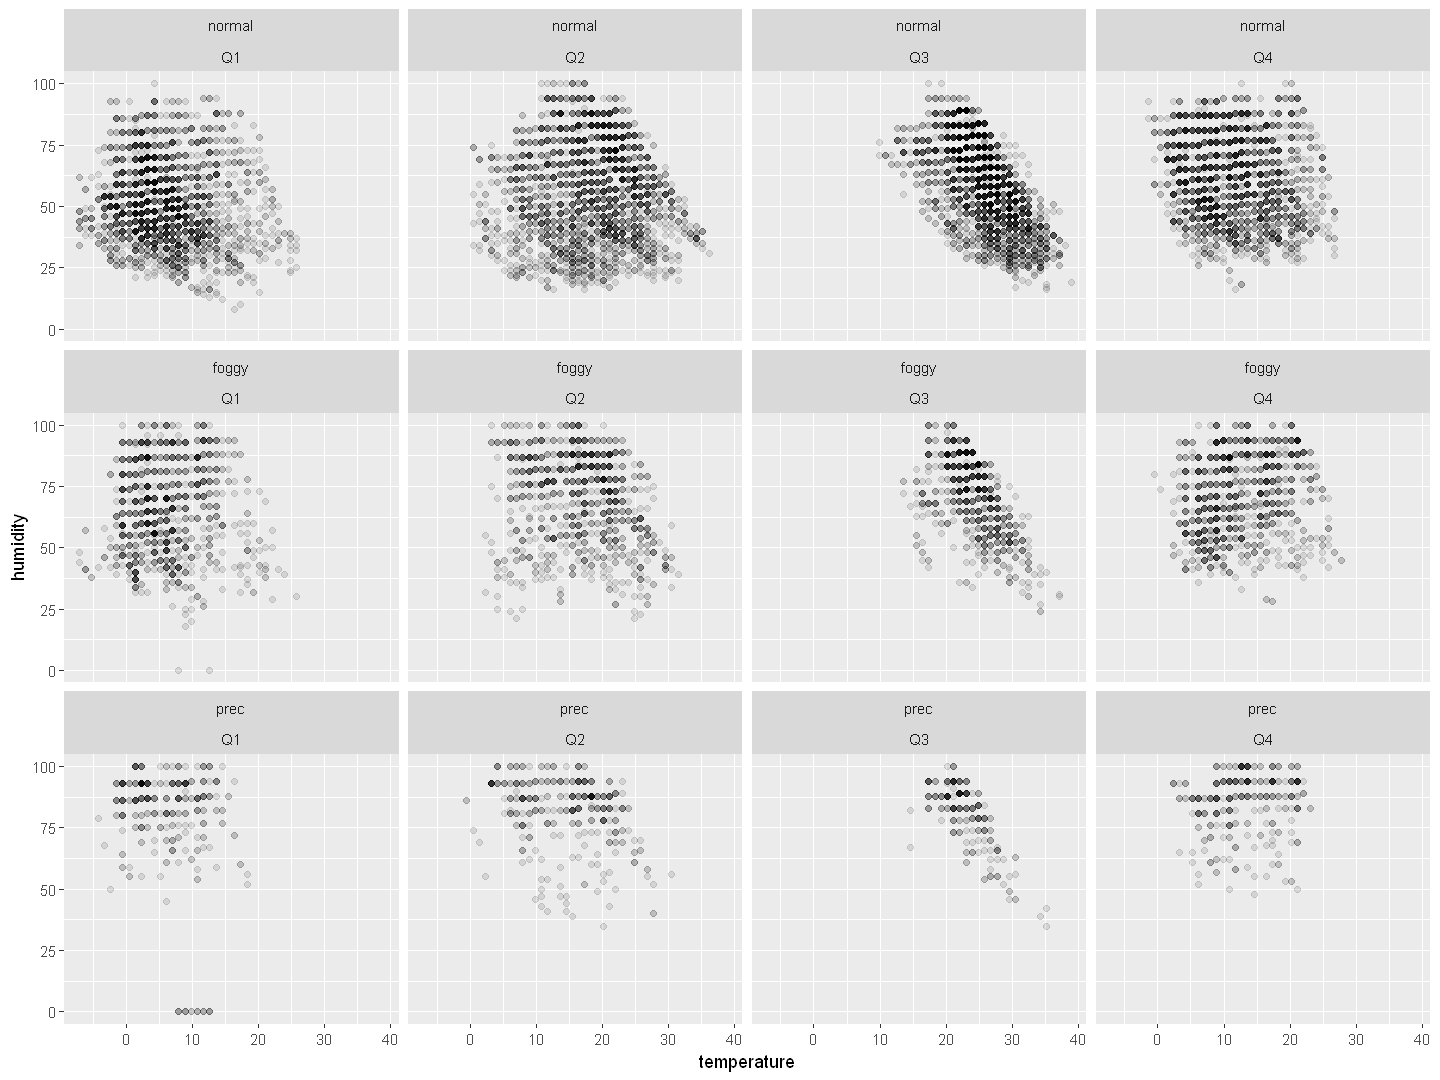

In [273]:
# check the range of temperautre and humidity that can be fit 
ggplot(data,aes(x=temperature, y=humidity))+
    geom_point(alpha=0.1)+
    facet_wrap(~weather+season, ncol=4)

In [23]:
# fitdata generation
get_fitdata <- function(season, weather, temperature, humidity){
    return (expand.grid(year=factor(c(2011,2012)),
                       season=factor(season, levels=c(1,2,3,4), labels = c('Q1','Q2','Q3','Q4')),
                       hour = factor(seq(0,23)),
                       month = factor(seq(1,12)),
                       workingday = factor(c(0,1), labels = c('non_workday','workday')),                      
                       weather= factor(weather, levels = c(1,2,3), labels = c('normal','foggy','prec')),
                       temperature = temperature,
                       humidity = humidity))
}

fitdatas=list(get_fitdata(season=c(2,4), weather=c(1,2), temperature=c(10,20), humidity=c(40,70)),
              get_fitdata(season=c(1), weather=c(1,2), temperature=c(0,10), humidity=c(40,70)),
              get_fitdata(season=c(3), weather=c(1,2), temperature=c(20,30), humidity=c(40,70)),
              get_fitdata(season=c(2,4), weather=c(3), temperature=c(10,20), humidity=c(60,90)),
              get_fitdata(season=c(1), weather=c(3), temperature=c(0,10), humidity=c(60,90)),
              get_fitdata(season=c(3), weather=c(3), temperature=c(20,30), humidity=c(60,90))
              )
fitdata = bind_rows(fitdatas)

fitdata[['predict']] = predict(mdl, newdata=fitdata)
fitdata = as.data.table(fitdata)
fitdata[,hour:=as.numeric(hour)]
fitdata[,weather_measure:=paste0('(',temperature,',',humidity,')')]
fitdata[,weather_measure:=factor(weather_measure, 
                                 levels=c('(0,70)','(0,40)','(10,70)','(10,40)','(20,70)','(20,40)','(30,70)','(30,40)',
                                          '(0,90)','(0,60)','(10,90)','(10,60)','(20,90)','(20,60)','(30,90)','(30,60)'
                                         ))]

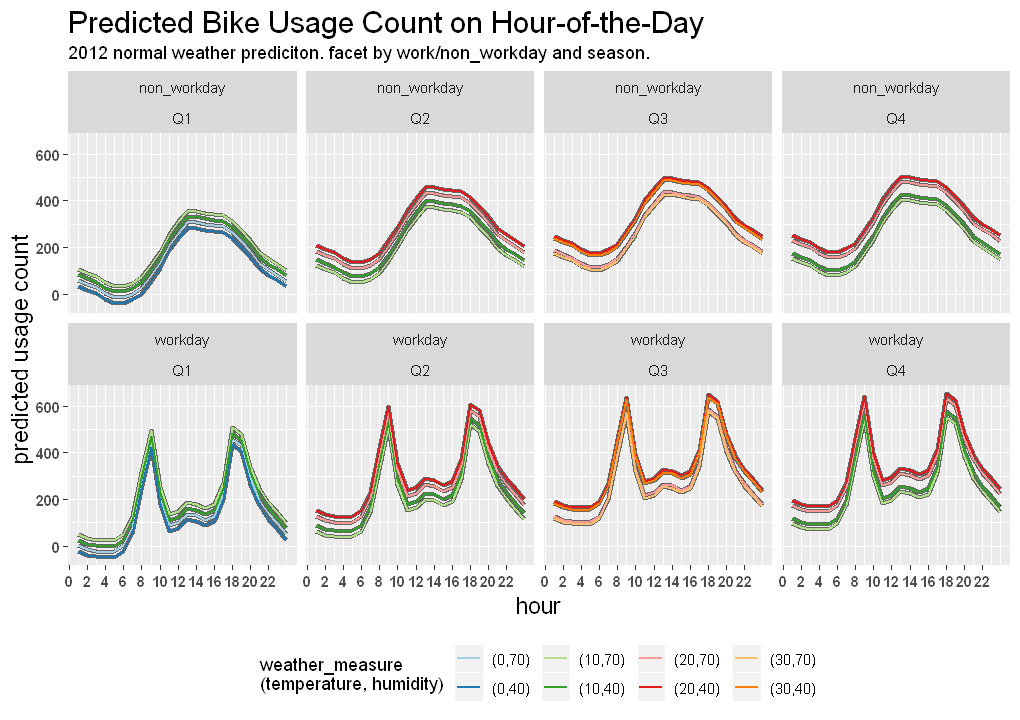

In [24]:
# draw the plots
draw <- function(data, width=8.5, heigth=6, subtitle){
  options(repr.plot.width=width, repr.plot.height=heigth)
  ggplot(data, aes(x=hour, y=predict, group=weather_measure, color=weather_measure))+
  geom_line(size=1.2, color='gray40')+  
  geom_line(size=0.7)+  
  facet_wrap(~ workingday+season, ncol=4)+
  scale_x_continuous(breaks=seq(0,23,2))+
  scale_color_brewer(name='weather_measure\n(temperature, humidity)', type='qualitative', palette='Paired')+
  labs(title = 'Predicted Bike Usage Count on Hour-of-the-Day',
       subtitle = subtitle,
       x='hour',y='predicted usage count')+
  theme(plot.title = element_text(size='18'),
        axis.text = element_text(size='9', face='bold'),
        axis.title = element_text(size='14',),
        legend.position="bottom", legend.box = "horizontal")
    
}

draw(fitdata[year==2012 & weather=='normal'],
     subtitle = '2012 normal weather prediciton. facet by work/non_workday and season.')

Observation
- Under normal weather condition, in non-workday,  model predicts season Q4(fall) has highest usage count, then Q3(summer), Q2(spring), and Q1(winter). But in work day, Q3 has more usage count than Q4. The other two season keep in the same order. 
- It is interesting that in season Q1 and Q4, "bad weather" in non-work day seems produce more usage reduction then in work day, which can be observed by the difference of highest and lowest curve in every facet subplot. It is reasonable since people have to commute in work day no matter how bad the weather is. However, we don't observe the same effect in season Q3 and Q1. No matter how good or bad the weather is, as long as in normal weather condition, people seems equally want or not want to use bike.
- Under normal weather condition, people use more bike in warm weather than in cool weather. The exception is in season Q3, since the temperature has already been pretty warm, in non-work day, temperature difference stop making difference on usage count, and in work day, people use even slightly less bike in warm weather(30 degree) than in cool weather (20 degree). Maybe 20 degree is too hot for commuting with bike. 
- Under normal weather condition, people use more bike in low humidity weather than high humidity weather, which is pretty reasonable. The only exception is in season Q1, people use bike slightly more in high humidity weather than in low humidity weather, which is quite strange.
- In season Q1, Q2 and Q4, in most of the cases, temperature variation (by the scale of 10 degree variation) seems do more impact on usage count then humidity variation (by the scale of 30% humidity variation). The two exception cases are non-work day in Q2 and work day in Q1. In these cases, temperature variation seems do about the same scale of impact as humidity variation. However, for season Q3, the relation is reversed. Since the weather is warm enough, the temperature differences has little impact on usage count, and humidity level determines usage count when other variables other than temperature hold equal. 

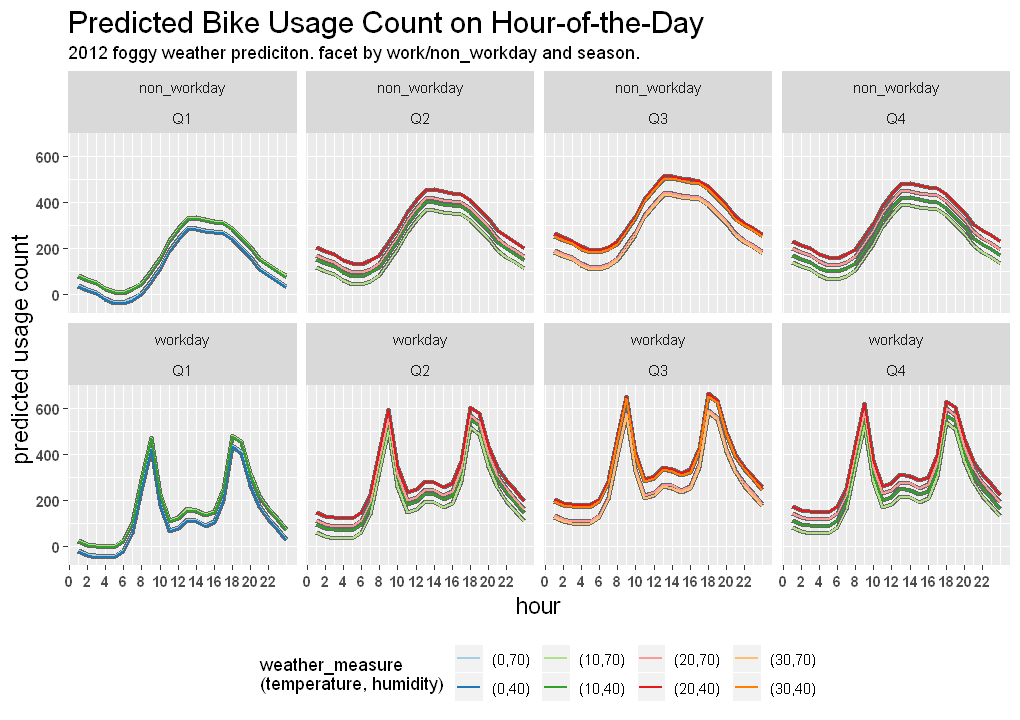

In [25]:
draw(fitdata[year==2012 & weather %in% c('foggy'),],
     subtitle = '2012 foggy weather prediciton. facet by work/non_workday and season.')

Observation
- Under foggy weather condition, no matter in work-day or non-workday, model predicts the usage count of Q3(summer) is higher than the rest of the seasons. Q4(fall) and Q2 (spring) are about has the same usage count, and both seasons are higher than Q1. 
- "Bad weather" effect is more significant under foggy weather condition. In season Q2, Q3, and Q4, when weather is bad, the reduction of usage count is more in non-work days than in work days. In season Q1, people just equally reluctant to ride a bike in foggy weather, no matter how good the weather measure is.
- Same as the normal weather condition, under foggy weather condition, people use more bike in warm weather than in cool weather. The exception, again, is the work days in season Q3, Even in cloudy or foggy days, 30 degree seems still too hot for commuting with bike in summer.
- Under foggy weather condition, people still use more bike in low humidity weather than in high humidity weather. The only exception remains: in season Q1, people use bike slightly more in high humidity weather than in low humidity weather.
- Very different from normal weather condition, under foggy weather condition, in season Q1, Q2 and Q4, temperature and humidity variation seems do the same amount of impact on usage count. By contrast, in season Q3, the relation holds the same as under normal weather condition: temperature variation remain has little impact on usage count in foggy days in season Q3.

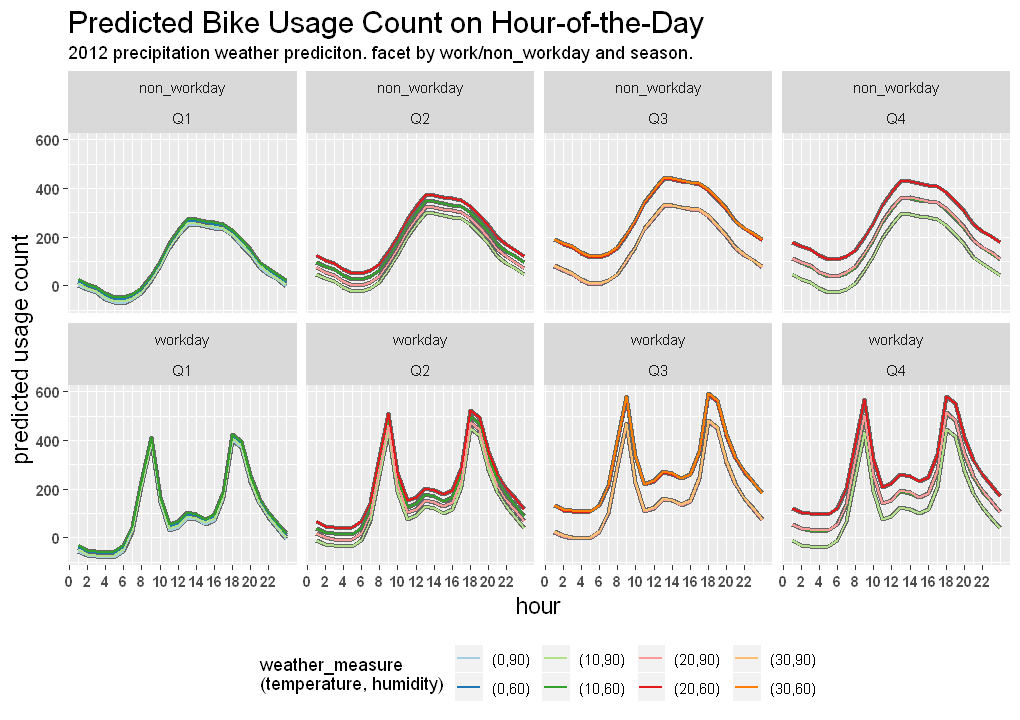

In [26]:
draw(fitdata[year==2012 & weather %in% c('prec')],
     subtitle = '2012 precipitation weather prediciton. facet by work/non_workday and season.')

Observation
- Under precipitation weather condition, model predicts the usage count of Q3(summer) is higher than the rest of the seasons, then Q4(fall), Q2(spring), and Q1(winter), no matter in work-day or in non-work day.
- "Bad weather" effect seams disappear under precipitation weather condition. People just equally reluctant to ride a bike under precipitation weather condition, no matter it is in which season, is a work day or a non-work day.
- Under precipitation weather condition, generally speaking, people use more bike in warm weather than in cool weather. The only exception is non-work day in season Q1. People use more bike in cold weather than in warm weather in these days, which is quite strange. 
- Under precipitation weather condition, people use more bike in low humidity weather than in high humidity weather, with no exception.
- Same as precipitation weather condition, in season Q1, Q2 and Q4, temperature and humidity variation seems do the same amount of impact on usage count. As for season Q3, temperature variation still has little impact on usage count.